In [1]:
from psaw import PushshiftAPI

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud, STOPWORDS

/home/parth/aa_workingspace/FakeNews/fakenewsvenv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
### Data scrape

###### Uncomment and run only once ######
# def scrape_data(subreddit):
    
#     # Instantiate 
#     api = PushshiftAPI()

#     # Create list of scraped data
#     scrape_list = list(api.search_submissions(subreddit=subreddit,
#                                 filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
#                                 limit=15000))

#     #Filter list to only show Subreddit titles and Subreddit category 
#     clean_scrape_lst = []
#     for i in range(len(scrape_list)):
# #         if(scrape_list[i][4] < 2):   # if you want to utilise the score of reddit posts
# #             continue
#         scrape_dict = {}
#         scrape_dict['subreddit'] = scrape_list[i][5]
#         scrape_dict['author'] = scrape_list[i][0]
#         scrape_dict['domain'] = scrape_list[i][2]
#         scrape_dict['title'] = scrape_list[i][7]
#         scrape_dict['num_comments'] = scrape_list[i][3]
#         scrape_dict['score'] = scrape_list[i][4]
#         scrape_dict['timestamp'] = scrape_list[i][1]
#         clean_scrape_lst.append(scrape_dict)
    
#     # Return list of scraped data
#     return clean_scrape_lst

In [3]:
# df_not_onion = pd.DataFrame(scrape_data('nottheonion'))

# # Save data to csv
# df_not_onion.to_csv('not_onion.csv')

# # Shape of DataFrame
# print(f'df_not_onion shape: {df_not_onion.shape}')

# # Show head
# df_not_onion.head()

In [4]:
# # Call function and create DataFrame
# df_onion = pd.DataFrame(scrape_data('theonion'))

# # Save data to csv
# df_onion.to_csv('the_onion.csv')

# # Shape of DataFrame
# print(f'df_onion shape: {df_onion.shape}')

# # Show head
# df_onion.head()

In [5]:
df_onion = pd.read_csv('the_onion.csv')
df_notonion = pd.read_csv('not_onion.csv')

In [8]:
df_onion.head()
print(df_onion.shape)
print(df_notonion.shape)

(14978, 8)
(15000, 8)


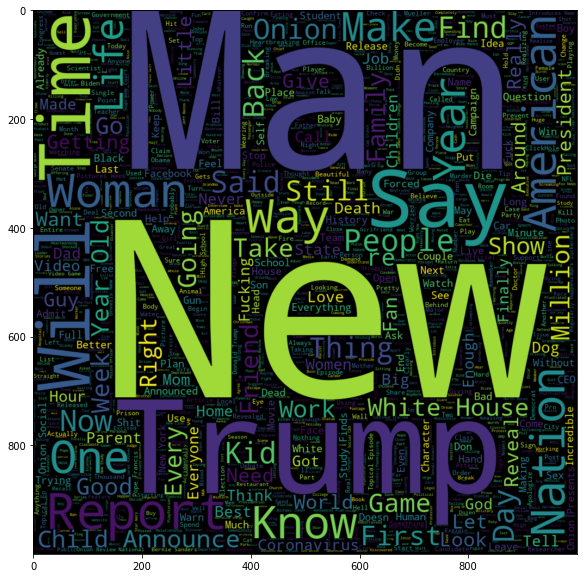

In [9]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, stopwords = STOPWORDS, height = 1000, width = 1000).generate(' '.join(df_onion['title']))
plt.imshow(wc , interpolation = 'bilinear')

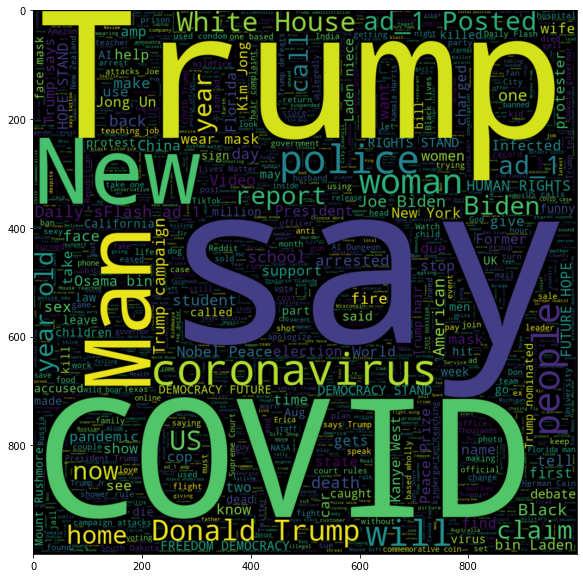

In [10]:
plt.figure(figsize = (10, 10))
wc = WordCloud(max_words = 2000, stopwords = STOPWORDS, height = 1000, width = 1000).generate(' '.join(df_notonion['title']))
plt.imshow(wc , interpolation = 'bilinear')

In [12]:
def clean_data(dataframe):

    dataframe.drop_duplicates(subset='title', inplace=True)
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [13]:
clean_data(df_onion)

New shape: (13948, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,TheOnion,dwaxe,ogn.theonion.com,someone needs to explain the upcoming games in...,0,1,1602244962
1,1,TheOnion,JJGerms,theonion.com,study boyfriends who aren t speaking are think...,0,1,1602206569
2,2,TheOnion,JJGerms,theonion.com,man at party comes crawling back to conversati...,0,1,1602206417
3,3,TheOnion,tomato_soup_,politics.theonion.com,yee haw my vote cancels out y all s,1,1,1602188130
4,4,TheOnion,aresef,theonion.com,american populace worried they re not likable ...,4,1,1602184611


In [14]:
clean_data(df_notonion)

New shape: (11692, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,nottheonion,TheKelseyOfKells,bbc.co.uk,why some onions were too sexy for facebook,1,1,1602241487
1,1,nottheonion,L1ng,theguardian.com,covid drug given to trump developed using cell...,0,1,1602241404
2,2,nottheonion,DemonTime123,share.getpaidto.app,check this out,0,1,1602240514
3,3,nottheonion,houska22,praguemorning.cz,prague shopping centers switch off wi fi to de...,1,1,1602239625
4,4,nottheonion,desi_guy1,npr.org,npr electoral map biden lead widens again with...,11,1,1602236838


In [15]:
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_notonion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)
df

,subreddit,title
0,TheOnion,someone needs to explain the upcoming games in...
1,TheOnion,study boyfriends who aren t speaking are think...
2,TheOnion,man at party comes crawling back to conversati...
3,TheOnion,yee haw my vote cancels out y all s
4,TheOnion,american populace worried they re not likable ...
...,...,...
25635,nottheonion,iranian death metal band arsames were arrested...
25636,nottheonion,iranian metal band arsames arrested sentenced ...
25637,nottheonion,egypt tells elon musk pyramids were not built ...
25638,nottheonion,two cruise ships hit by coronavirus weeks afte...


In [16]:
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

In [17]:
df['subreddit'].value_counts(normalize = True)

1    0.543994
0    0.456006
Name: subreddit, dtype: float64

In [18]:
x = df['title']
y = df['subreddit']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y)

In [33]:
pipe = Pipeline([('tfidf', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {
               'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
               'lr__C': [1, 2, 3, 4, 5]
            }


gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(x_train, y_train);
print("Best score:", gs.best_score_)
print("Train score:", gs.score(x_train, y_train))
print("Test score:", gs.score(x_test, y_test))

gs.best_params_

Best score: 0.8368174726989079
Train score: 0.9602184087363494
Test score: 0.8414976599063962


{'lr__C': 5, 'tfidf__ngram_range': (1, 1)}

In [28]:
def clean(title):
    title = title.replace('[^\w\s]',' ')
    title = title.replace('[^A-Za-z]',' ')
    title = title.replace('  ', ' ')
    title = title.lower()
    return title

In [34]:
# correct prediction
np.argmax(gs.predict_proba([clean('White House Staff Heartbroken By Sight Of Weak Trump Struggling To Yell Racial Slurs At TV')]))

1

In [35]:
# incorrect prediction
np.argmax(gs.predict_proba([clean('Kamala Harris says Trump is the greatest President America will ever have.')]))

0

In [36]:
# correct prediction
np.argmax(gs.predict_proba([clean('Panicked Donald Trump Jr. Tries To Cover Up Contact With WikiLeaks By Deleting Firefox Icon From Desktop')]))

1

In [30]:
pipe = Pipeline([('cv', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

pipe_params = {
               'cv__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
               'lr__C': [1, 2, 3, 4, 5]
            }



gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(x_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(x_train, y_train))
print("Test score", gs.score(x_test, y_test))

gs.best_params_

Best score: 0.8314092563702548
Train score 0.9734789391575663
Test score 0.8382215288611544


{'cv__ngram_range': (1, 1), 'lr__C': 2}

In [31]:
# correct prediction
np.argmax(gs.predict_proba([clean('White House Staff Heartbroken By Sight Of Weak Trump Struggling To Yell Racial Slurs At TV')]))

1

In [32]:
# incorrect prediction
np.argmax(gs.predict_proba([clean('Kamala Harris says Trump is the greatest President America will ever have.')]))

0

In [37]:
# correct prediction
np.argmax(gs.predict_proba([clean('Panicked Donald Trump Jr. Tries To Cover Up Contact With WikiLeaks By Deleting Firefox Icon From Desktop')]))

1